# Preprocessing

In [1]:
import seaborn as sns
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
# import pytorch_lightning as pl


from transformers import (
    AdamW,
    AutoTokenizer,
    RobertaTokenizerFast,
    T5ForConditionalGeneration,
    T5TokenizerFast,
    AutoTokenizer,
    PreTrainedTokenizerFast,
    T5ForTokenClassification,
    RobertaTokenizerFast,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup
)

label2id = {'O': 0, 'B-ALG': 1, 'I-ALG': 2, 'B-APP': 3, 'I-APP': 4, 'B-CB': 5, 'I-CB': 6, 'B-CLA': 7, 'I-CLA': 8, 'B-DEV': 9, 'I-DEV': 10, 'B-DS': 11, 'I-DS': 12, 'B-DT': 13, 'I-DT': 14, 'B-FN': 15, 'I-FN': 16, 'B-FT': 17, 'I-FT': 18, 'B-FUN': 19, 'I-FUN': 20, 'B-HXT': 21, 'I-HXT': 22, 'B-LAN': 23, 'I-LAN': 24, 'B-LIB': 25, 'I-LIB': 26, 'B-OS': 27, 'I-OS': 28, 'B-UIE': 29, 'I-UIE': 30, 'B-UN': 31, 'I-UN': 32, 'B-VAL': 33, 'I-VAL': 34, 'B-VAR': 35, 'I-VAR': 36, 'B-VER': 37, 'I-VER': 38, 'B-WEB': 39, 'I-WEB': 40}
id2label = {label2id[x]: x for x in label2id}
labels = ['Algorithm', 'Application', 'Class', 'Code_Block', 'Data_Structure', 'Data_Type', 'Device', 'File_Name', 'File_Type', 'Function', 'HTML_XML_Tag', 'Language', 'Library', 'Operating_System', 'User_Interface_Element', 'User_Name', 'Value', 'Variable', 'Version', 'Website']
labels_short = ['ALG', 'APP', 'CB', 'CLA', 'DEV', 'DS', 'DT', 'FN', 'FT', 'FUN', 'HXT', 'LAN', 'LIB', 'OS', 'UIE', 'UN', 'VAL', 'VAR', 'VER', 'WEB']
short2long = {'ALG': 'Algorithm', 'APP': 'Application', 'CLA': 'Class', 'CB': 'Code_Block', 'DS': 'Data_Structure', 'DT': 'Data_Type', 'DEV': 'Device', 'FN': 'File_Name', 'FT': 'File_Type', 'FUN': 'Function', 'HXT': 'HTML_XML_Tag', 'LAN': 'Language', 'LIB': 'Library', 'OS': 'Operating_System', 'UIE': 'User_Interface_Element', 'UN': 'User_Name', 'VAL': 'Value', 'VAR': 'Variable', 'VER': 'Version', 'WEB': 'Website'}

path_save_image = "../figs/plot_baseline_clf_base_"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abuboba\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from datasets import load_dataset
import datasets
datasets.builder.has_sufficient_disk_space = lambda needed_bytes, directory='.': True


path = "../data/StackOverflow/json/"

dataset = load_dataset('json', data_files=os.path.join(path, 'data_train.json'))
dataset["test"] = load_dataset('json', data_files=os.path.join(path, 'data_test.json'))["train"]
dataset["validation"] = load_dataset('json', data_files=os.path.join(path, 'data_dev.json'))["train"]


In [3]:
model_code_name = "microsoft/codebert-base"
tokenizer_code = RobertaTokenizerFast.from_pretrained(model_code_name, add_prefix_space=True)
model_code = AutoModelForTokenClassification.from_pretrained(
    "../checkpoints/codebert-base-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)

model_name = "FacebookAI/roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name, add_prefix_space=True)
model = AutoModelForTokenClassification.from_pretrained(
    "../checkpoints/roberta-base-token-clf/checkpoint-11580", num_labels=len(label2id), id2label=id2label, label2id=label2id, device_map='cuda:0'
)#.to("cuda")

In [4]:
import pickle

def save_pickle(dct, name):
    with open(f'../pickles/{name}.pickle', 'wb') as f:
        pickle.dump(dct, f)

def load_pickle(name):
    data = None
    with open(f'../pickles/{name}.pickle', 'rb') as f:
        data = pickle.load(f)
    return data

In [5]:
def tokenize_and_align_labels(examples, tokenizer):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [6]:
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer})
tokenized_dataset_code = dataset.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_code})

Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

# Results

In [7]:
import numpy as np
import evaluate

seqeval = evaluate.load("seqeval")
label_list = list(label2id.keys())

def compute_metrics(p, full=False):
    predictions, labels = p

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    if full:
        return results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

## Validation set

In [27]:
# pred = []
# pred_code = []
# for item in tokenized_dataset["validation"]:
#     a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
#     pred.extend(predictions)
#     # print(compute_metrics((model(**a).logits.cpu().detach(), tokenized_dataset["test"]["labels"]), full=True))


# for item in tokenized_dataset_code["validation"]:
#     a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
#     pred_code.extend(predictions)

# dct = compute_metrics((pred, tokenized_dataset["validation"]["labels"]), True)
# dct_code = compute_metrics((pred_code, tokenized_dataset_code["validation"]["labels"]), True)

# save_pickle(dct, "roberta_val")
# save_pickle(dct_code, "codebert_val")

dct = load_pickle("roberta_val")
dct_code = load_pickle("codebert_val")
model_roberta = "RoBERTa"
model_codebert = "CodeBERT"

In [28]:
size_ovv, size_each, title = 20, 32, 0.93
size_sqr, size_title = 10, 20
size_f1 = 20

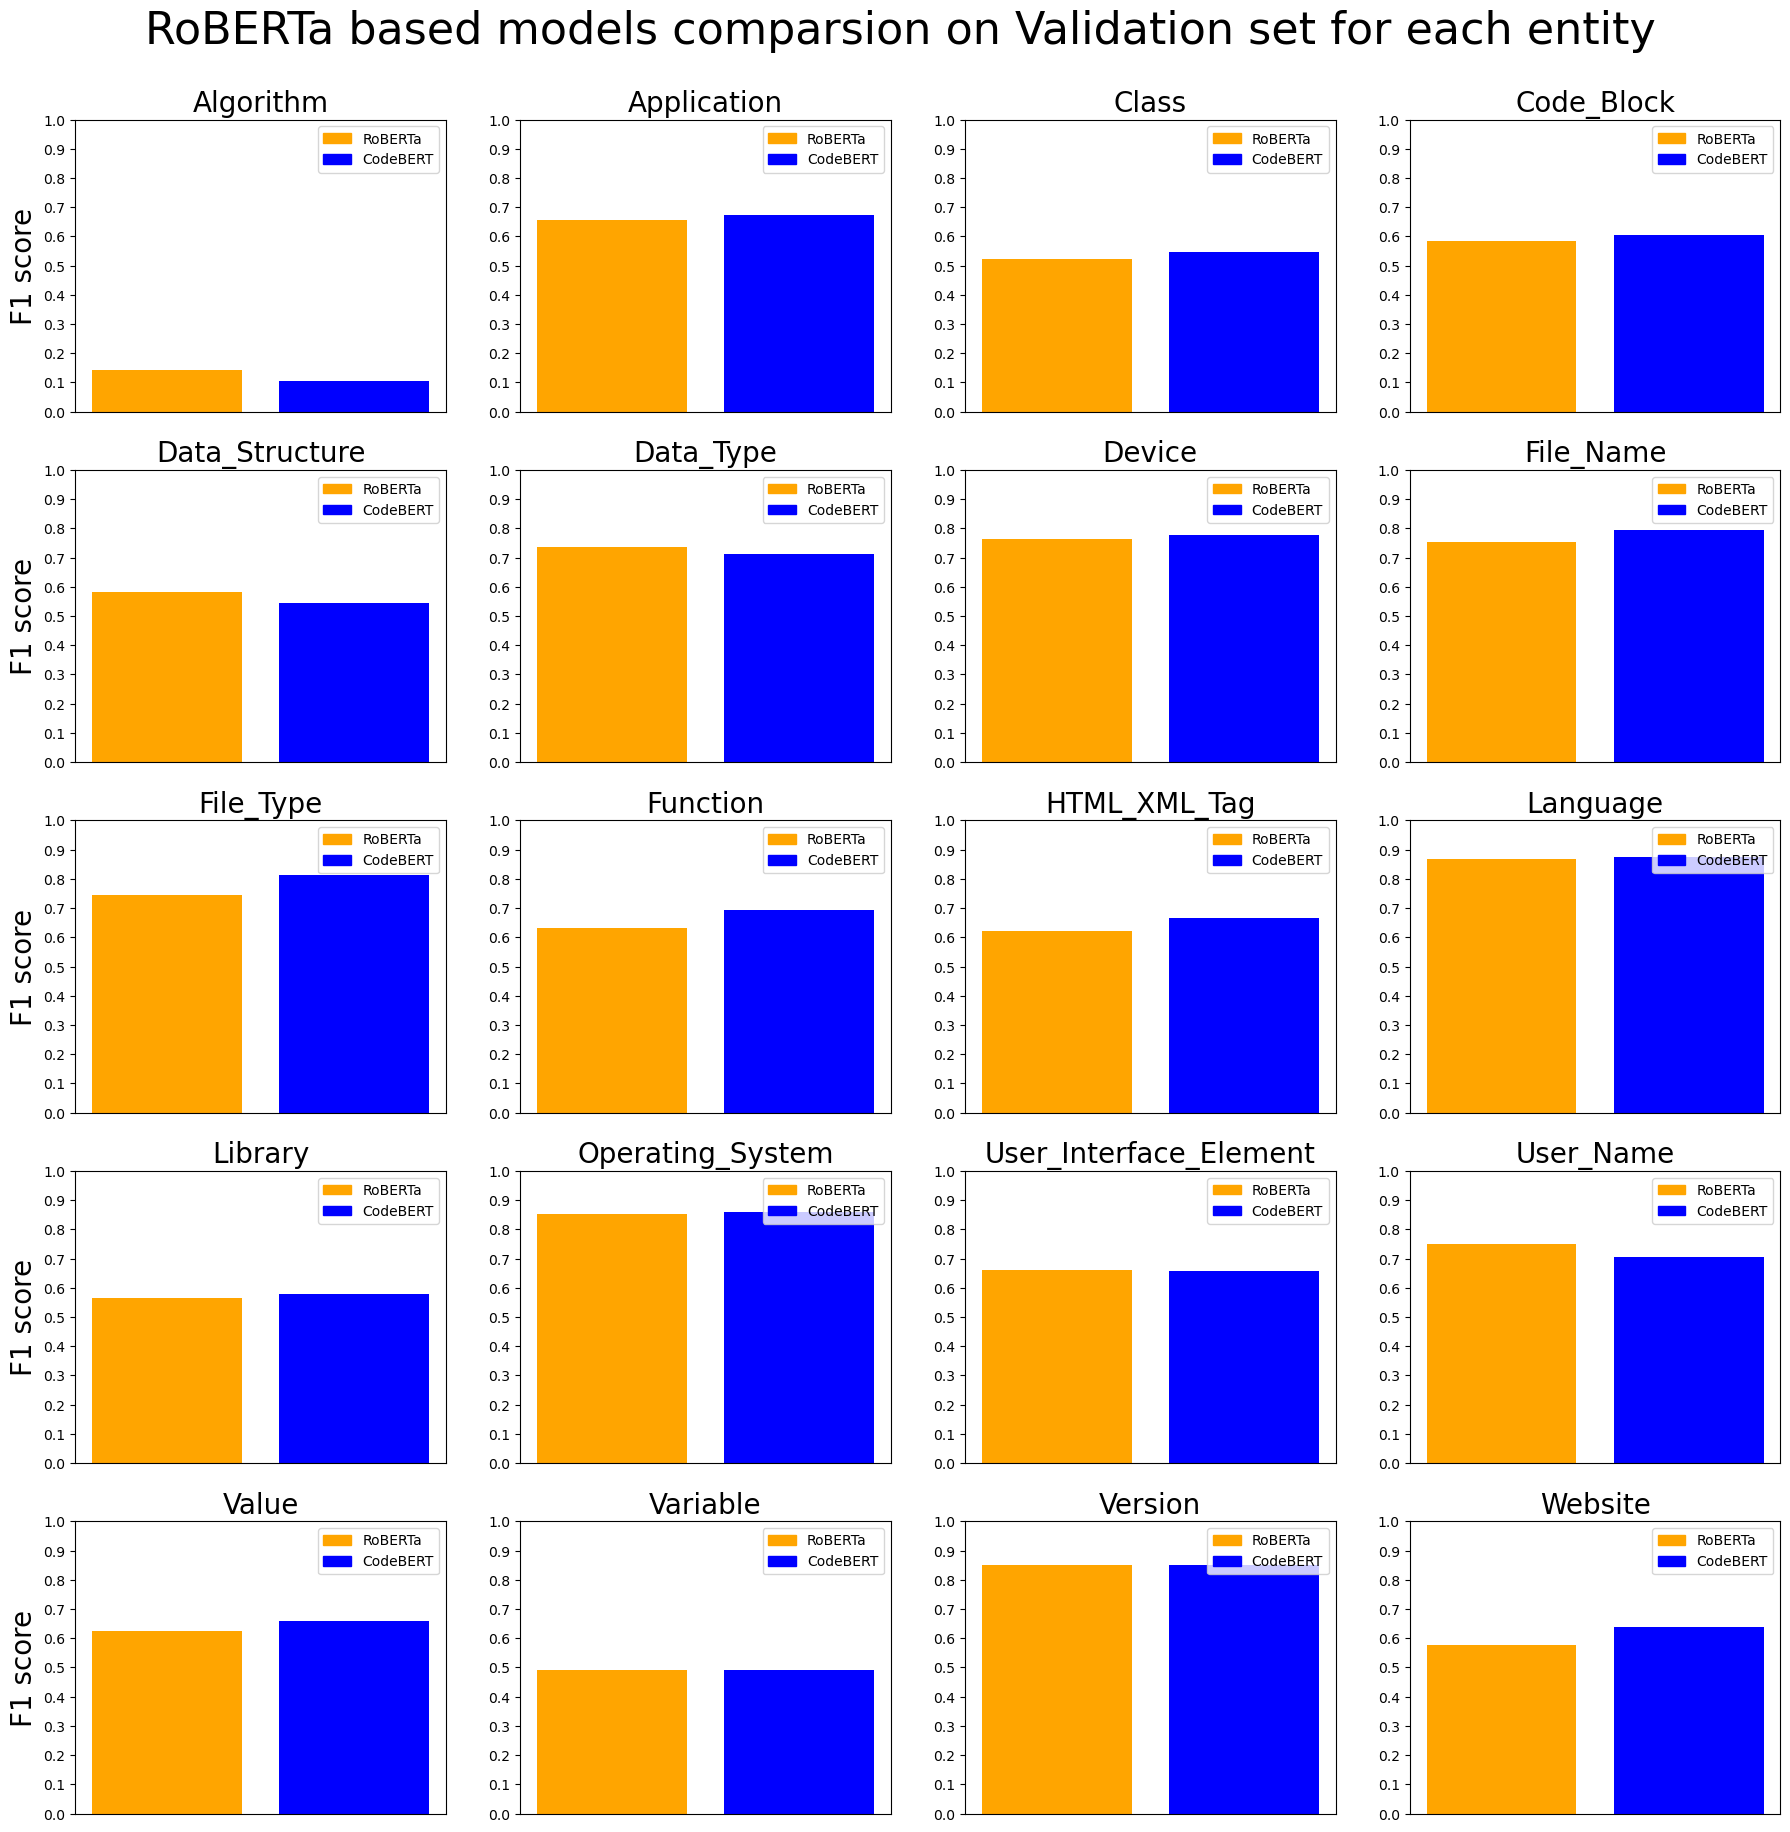

In [29]:
dct_arr = {x: dct[x]["f1"] for x in dct if "overall" not in x}
dct_arr_code = {x: dct_code[x]["f1"] for x in dct_code if "overall" not in x}

data = {
    model_roberta: list(dct_arr.values()),
    model_codebert: list(dct_arr_code.values())
}
length = len(list(dct_arr.values()))
X = [short2long[x] for x in dct_arr.keys()]
colors = ['orange', 'blue']

fig, axes = plt.subplots(5, 4, figsize =(22, 22))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i % 4 == 0:
        ax[i].set_ylabel('F1 score', fontsize = size_f1) 
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("RoBERTa based models comparsion on Validation set for each entity", fontsize=size_each, y=title)
plt.savefig(path_save_image + '0.png', bbox_inches='tight')
plt.show()

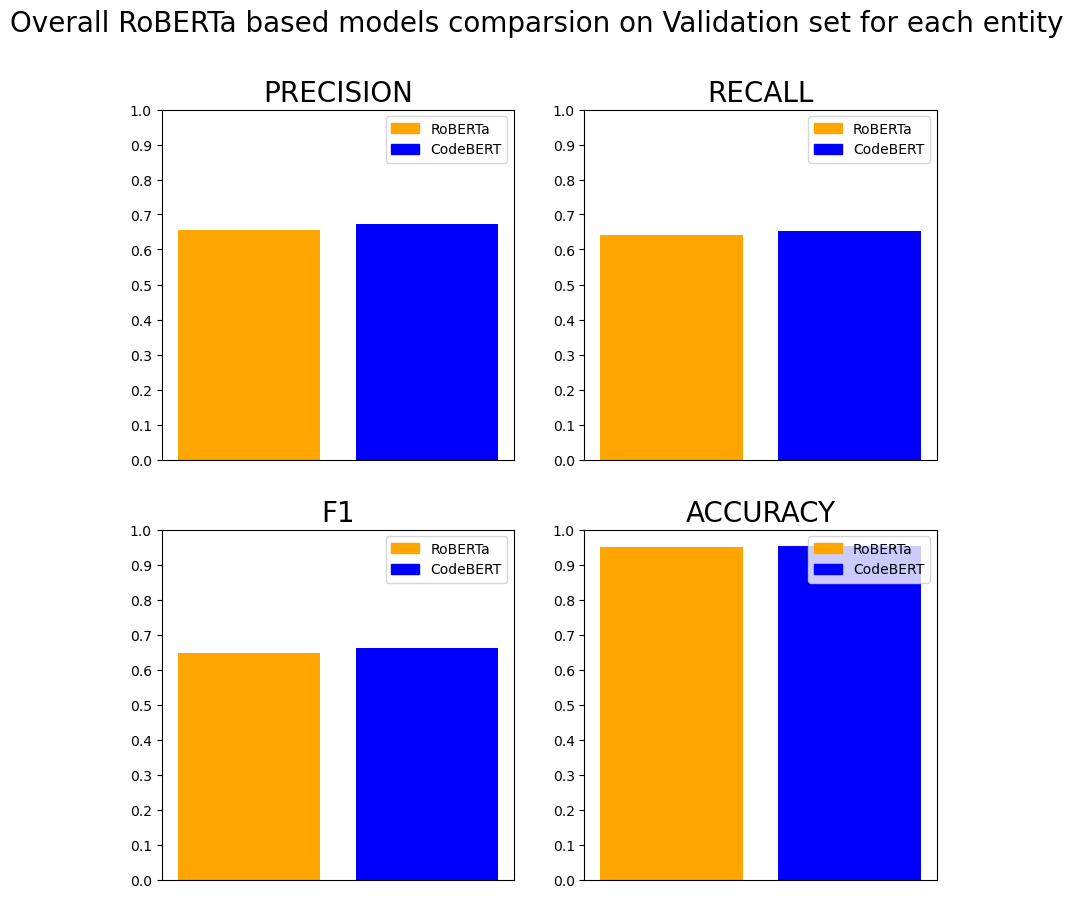

In [30]:
dct_arr = {x: dct[x] for x in dct if "overall"  in x}
dct_arr_code = {x: dct_code[x] for x in dct_code if "overall"  in x}

data = {
    model_roberta: list(dct_arr.values()),
    model_codebert: list(dct_arr_code.values())
}
length = len(list(dct_arr.values()))
X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
colors = ['orange', 'blue']

fig, axes = plt.subplots(2, 2, figsize =(10, 10))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("Overall RoBERTa based models comparsion on Validation set for each entity", fontsize=size_ovv)
plt.savefig(path_save_image + '1.png', bbox_inches='tight')
plt.show()

In [11]:
print(f"F1 scores on VALIDATION set:\n\n{model_name} - {dct['overall_f1']}\n{model_code_name} - {dct_code['overall_f1']}")

F1 scores on VALIDATION set:

FacebookAI/roberta-base - 0.6484043281742228
microsoft/codebert-base - 0.6627218934911242


# Test set

In [31]:
# pred = []
# pred_code = []
# for item in tokenized_dataset["test"]:
#     a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
#     pred.extend(predictions)


# for item in tokenized_dataset_code["test"]:
#     a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
#     pred_code.extend(predictions)

# dct = compute_metrics((pred, tokenized_dataset["test"]["labels"]), True)
# dct_code = compute_metrics((pred_code, tokenized_dataset_code["test"]["labels"]), True)

# save_pickle(dct, "roberta_test")
# save_pickle(dct_code, "codebert_test")

dct = load_pickle("roberta_test")
dct_code = load_pickle("codebert_test")

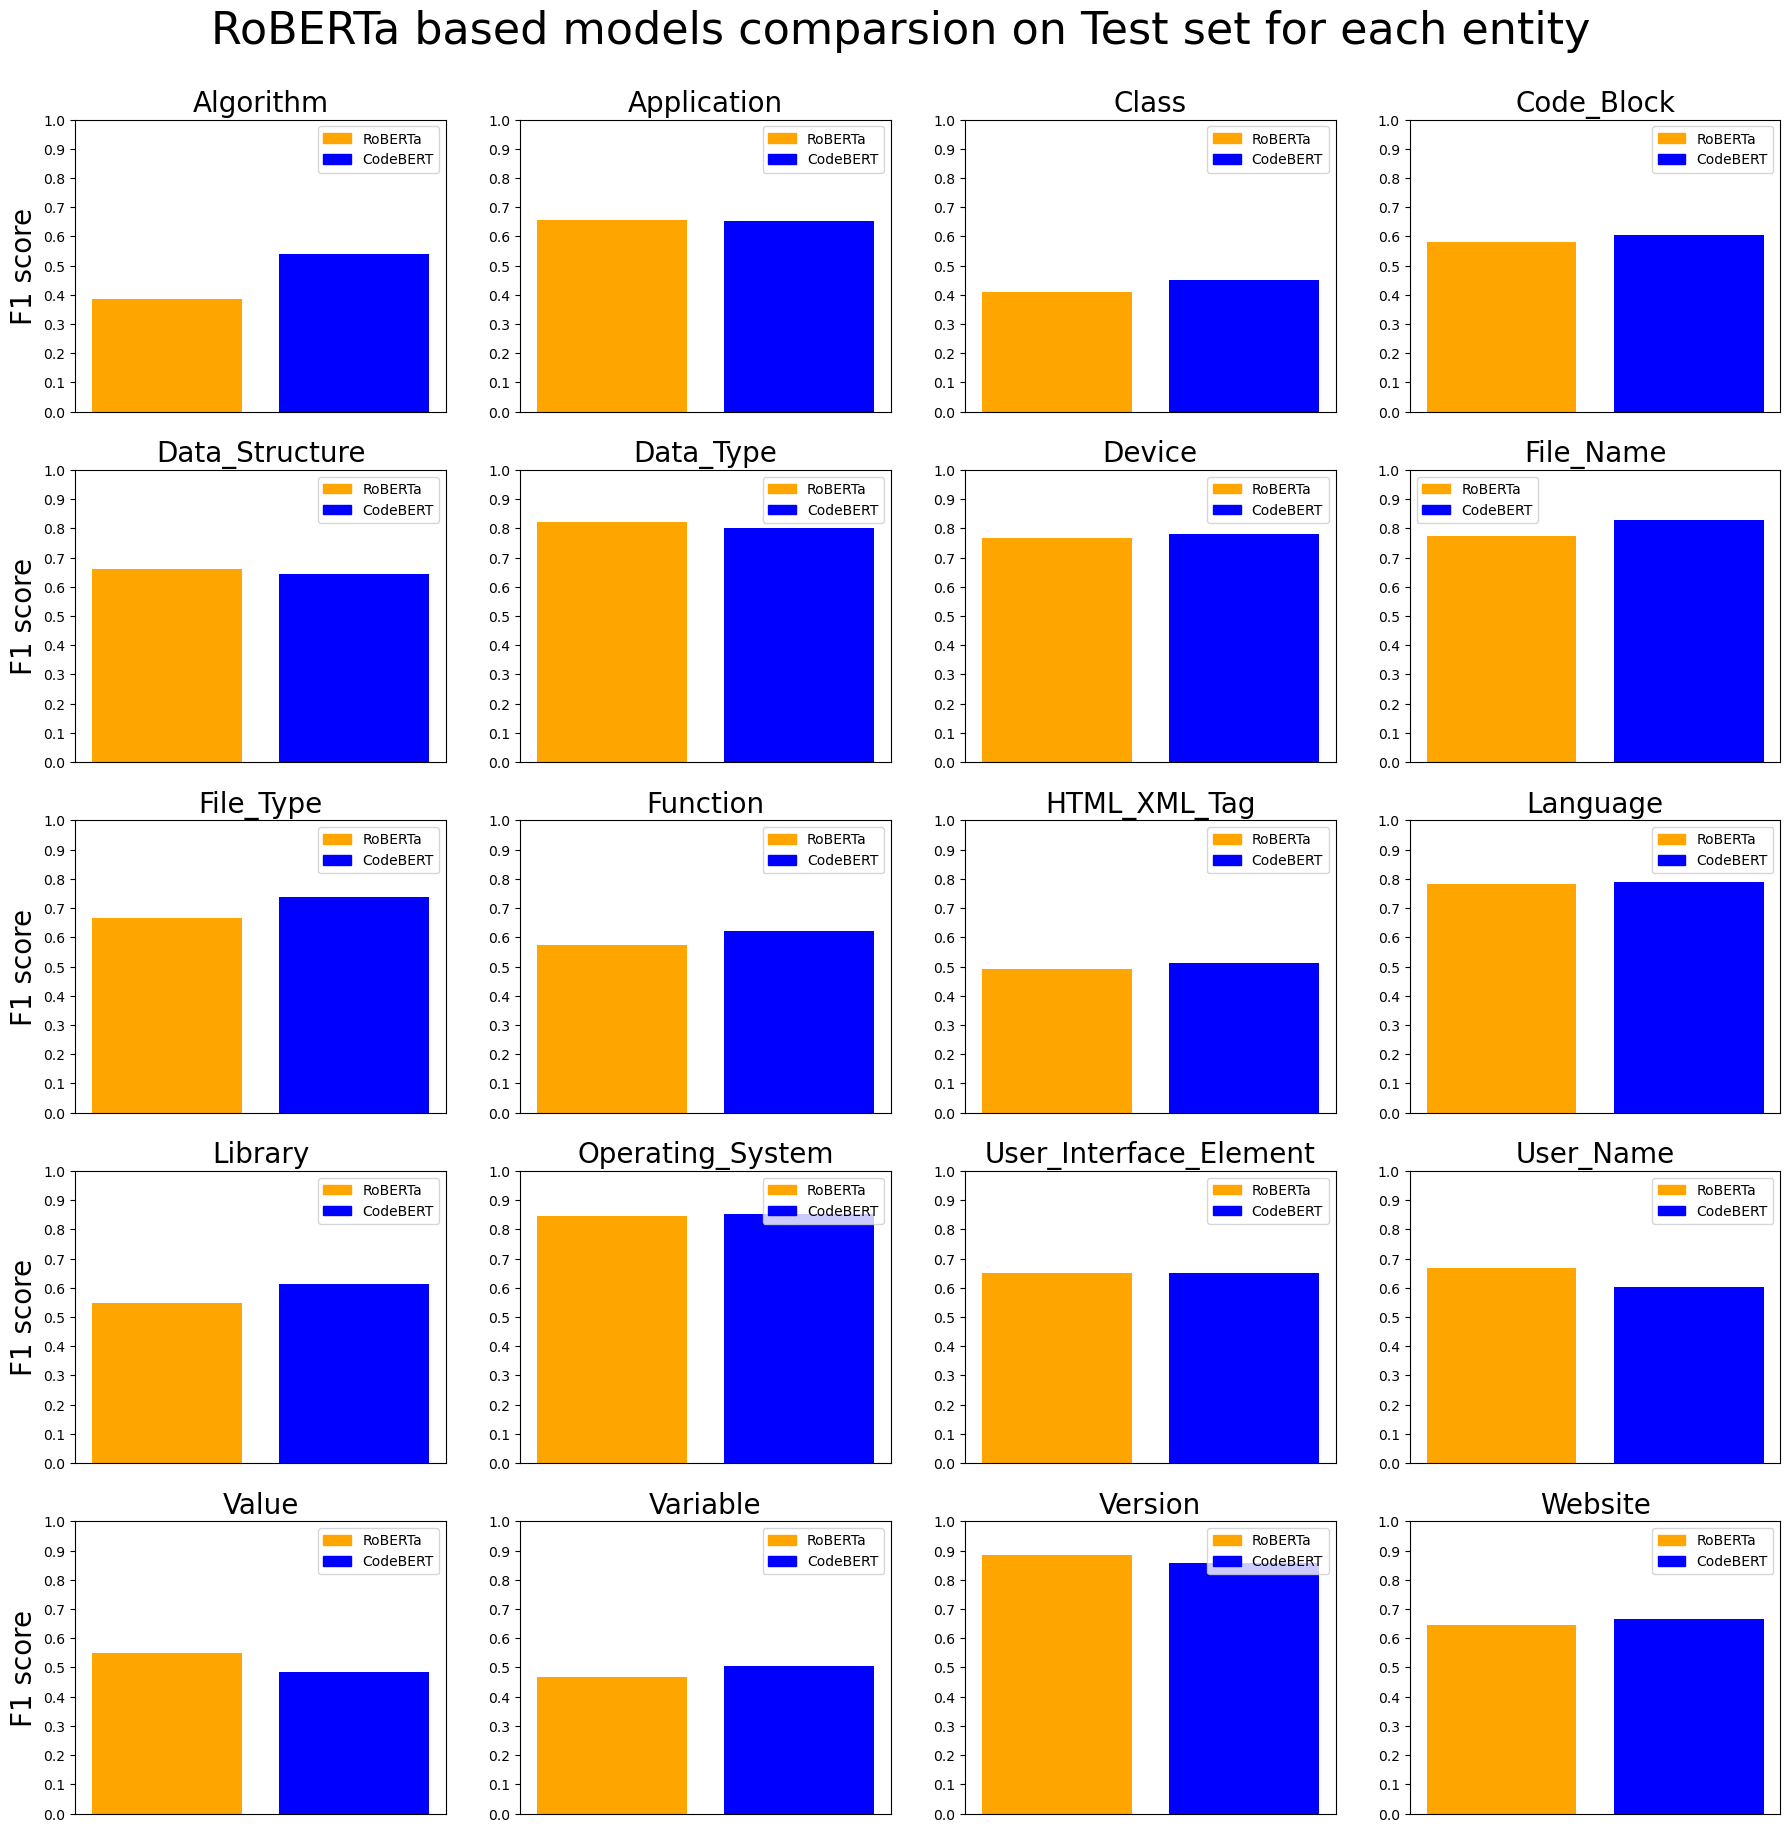

In [32]:
dct_arr = {x: dct[x]["f1"] for x in dct if "overall" not in x}
dct_arr_code = {x: dct_code[x]["f1"] for x in dct_code if "overall" not in x}

data = {
    model_roberta: list(dct_arr.values()),
    model_codebert: list(dct_arr_code.values())
}
length = len(list(dct_arr.values()))
X = [short2long[x] for x in dct_arr.keys()]
colors = ['orange', 'blue']

fig, axes = plt.subplots(5, 4, figsize =(22, 22))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i % 4 == 0:
        ax[i].set_ylabel('F1 score', fontsize = size_f1) 
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("RoBERTa based models comparsion on Test set for each entity", fontsize=size_each, y=title)
plt.savefig(path_save_image + '2.png', bbox_inches='tight')
plt.show()

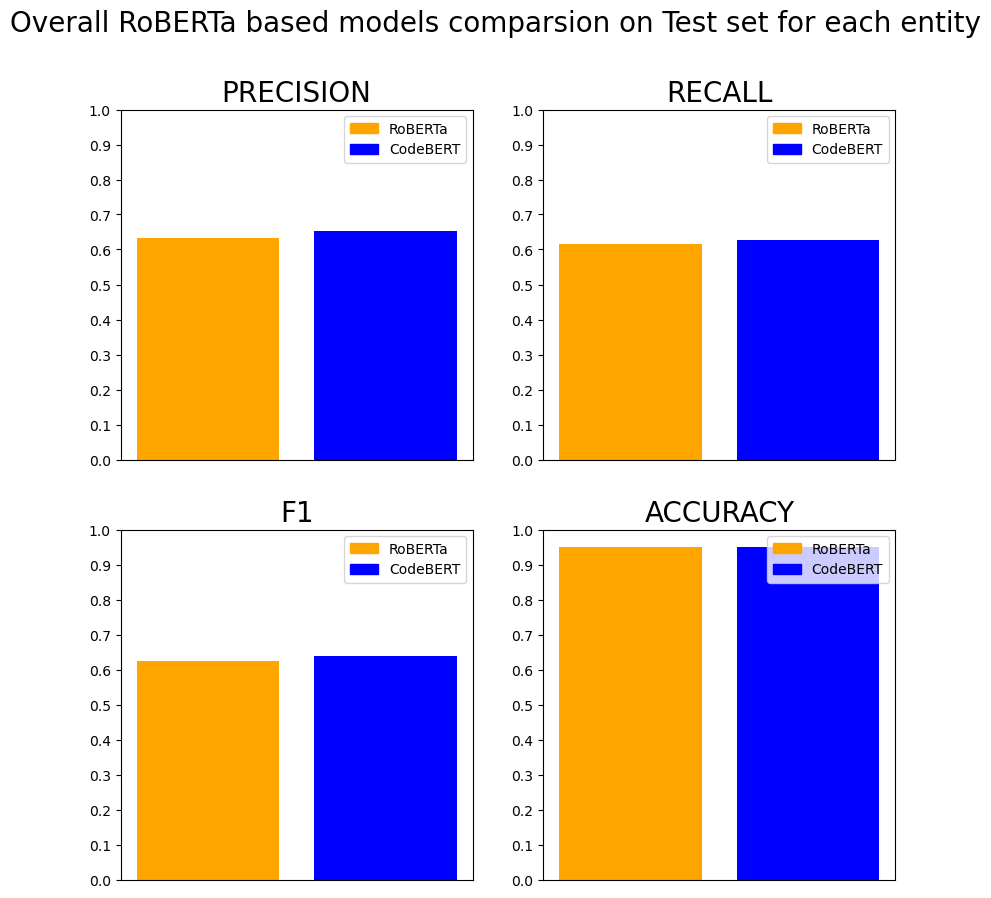

In [34]:
dct_arr = {x: dct[x] for x in dct if "overall"  in x}
dct_arr_code = {x: dct_code[x] for x in dct_code if "overall"  in x}

data = {
    model_roberta: list(dct_arr.values()),
    model_codebert: list(dct_arr_code.values())
}
length = len(list(dct_arr.values()))
X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
colors = ['orange', 'blue']

fig, axes = plt.subplots(2, 2, figsize =(10, 10))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("Overall RoBERTa based models comparsion on Test set for each entity", fontsize=size_ovv)
plt.savefig(path_save_image + '3.png', bbox_inches='tight')
plt.show()

In [15]:
print(f"F1 scores on TEST set:\n\n{model_name} - {dct['overall_f1']}\n{model_code_name} - {dct_code['overall_f1']}")

F1 scores on TEST set:

FacebookAI/roberta-base - 0.624168947985921
microsoft/codebert-base - 0.6397058823529412


# Domain adaptation

In [16]:
path_gh = "../data/GitHub/"
dataset_gh = load_dataset('json', data_files=os.path.join(path_gh, 'data_gh.json'))

In [17]:
tokenized_dataset_gh = dataset_gh.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer})
tokenized_dataset_code_gh = dataset_gh.map(tokenize_and_align_labels, batched=True, fn_kwargs={"tokenizer": tokenizer_code})

In [36]:
# pred = []
# pred_code = []
# for item in tokenized_dataset_gh["train"]:
#     a = tokenizer(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model(**a).logits.cpu().detach(), axis=2)
#     pred.extend(predictions)
#     # print(compute_metrics((model(**a).logits.cpu().detach(), tokenized_dataset["test"]["labels"]), full=True))


# for item in tokenized_dataset_code_gh["train"]:
#     a = tokenizer_code(item["tokens"],truncation=True, padding=True,is_split_into_words=True, return_tensors="pt").to("cuda")
#     predictions = np.argmax(model_code(**a).logits.cpu().detach(), axis=2)
#     pred_code.extend(predictions)

# dct = compute_metrics((pred, tokenized_dataset_gh["train"]["labels"]), True)
# dct_code = compute_metrics((pred_code, tokenized_dataset_code_gh["train"]["labels"]), True)

# save_pickle(dct, "roberta_gh")
# save_pickle(dct_code, "codebert_gh")

dct = load_pickle("roberta_gh")
dct_code = load_pickle("codebert_gh")

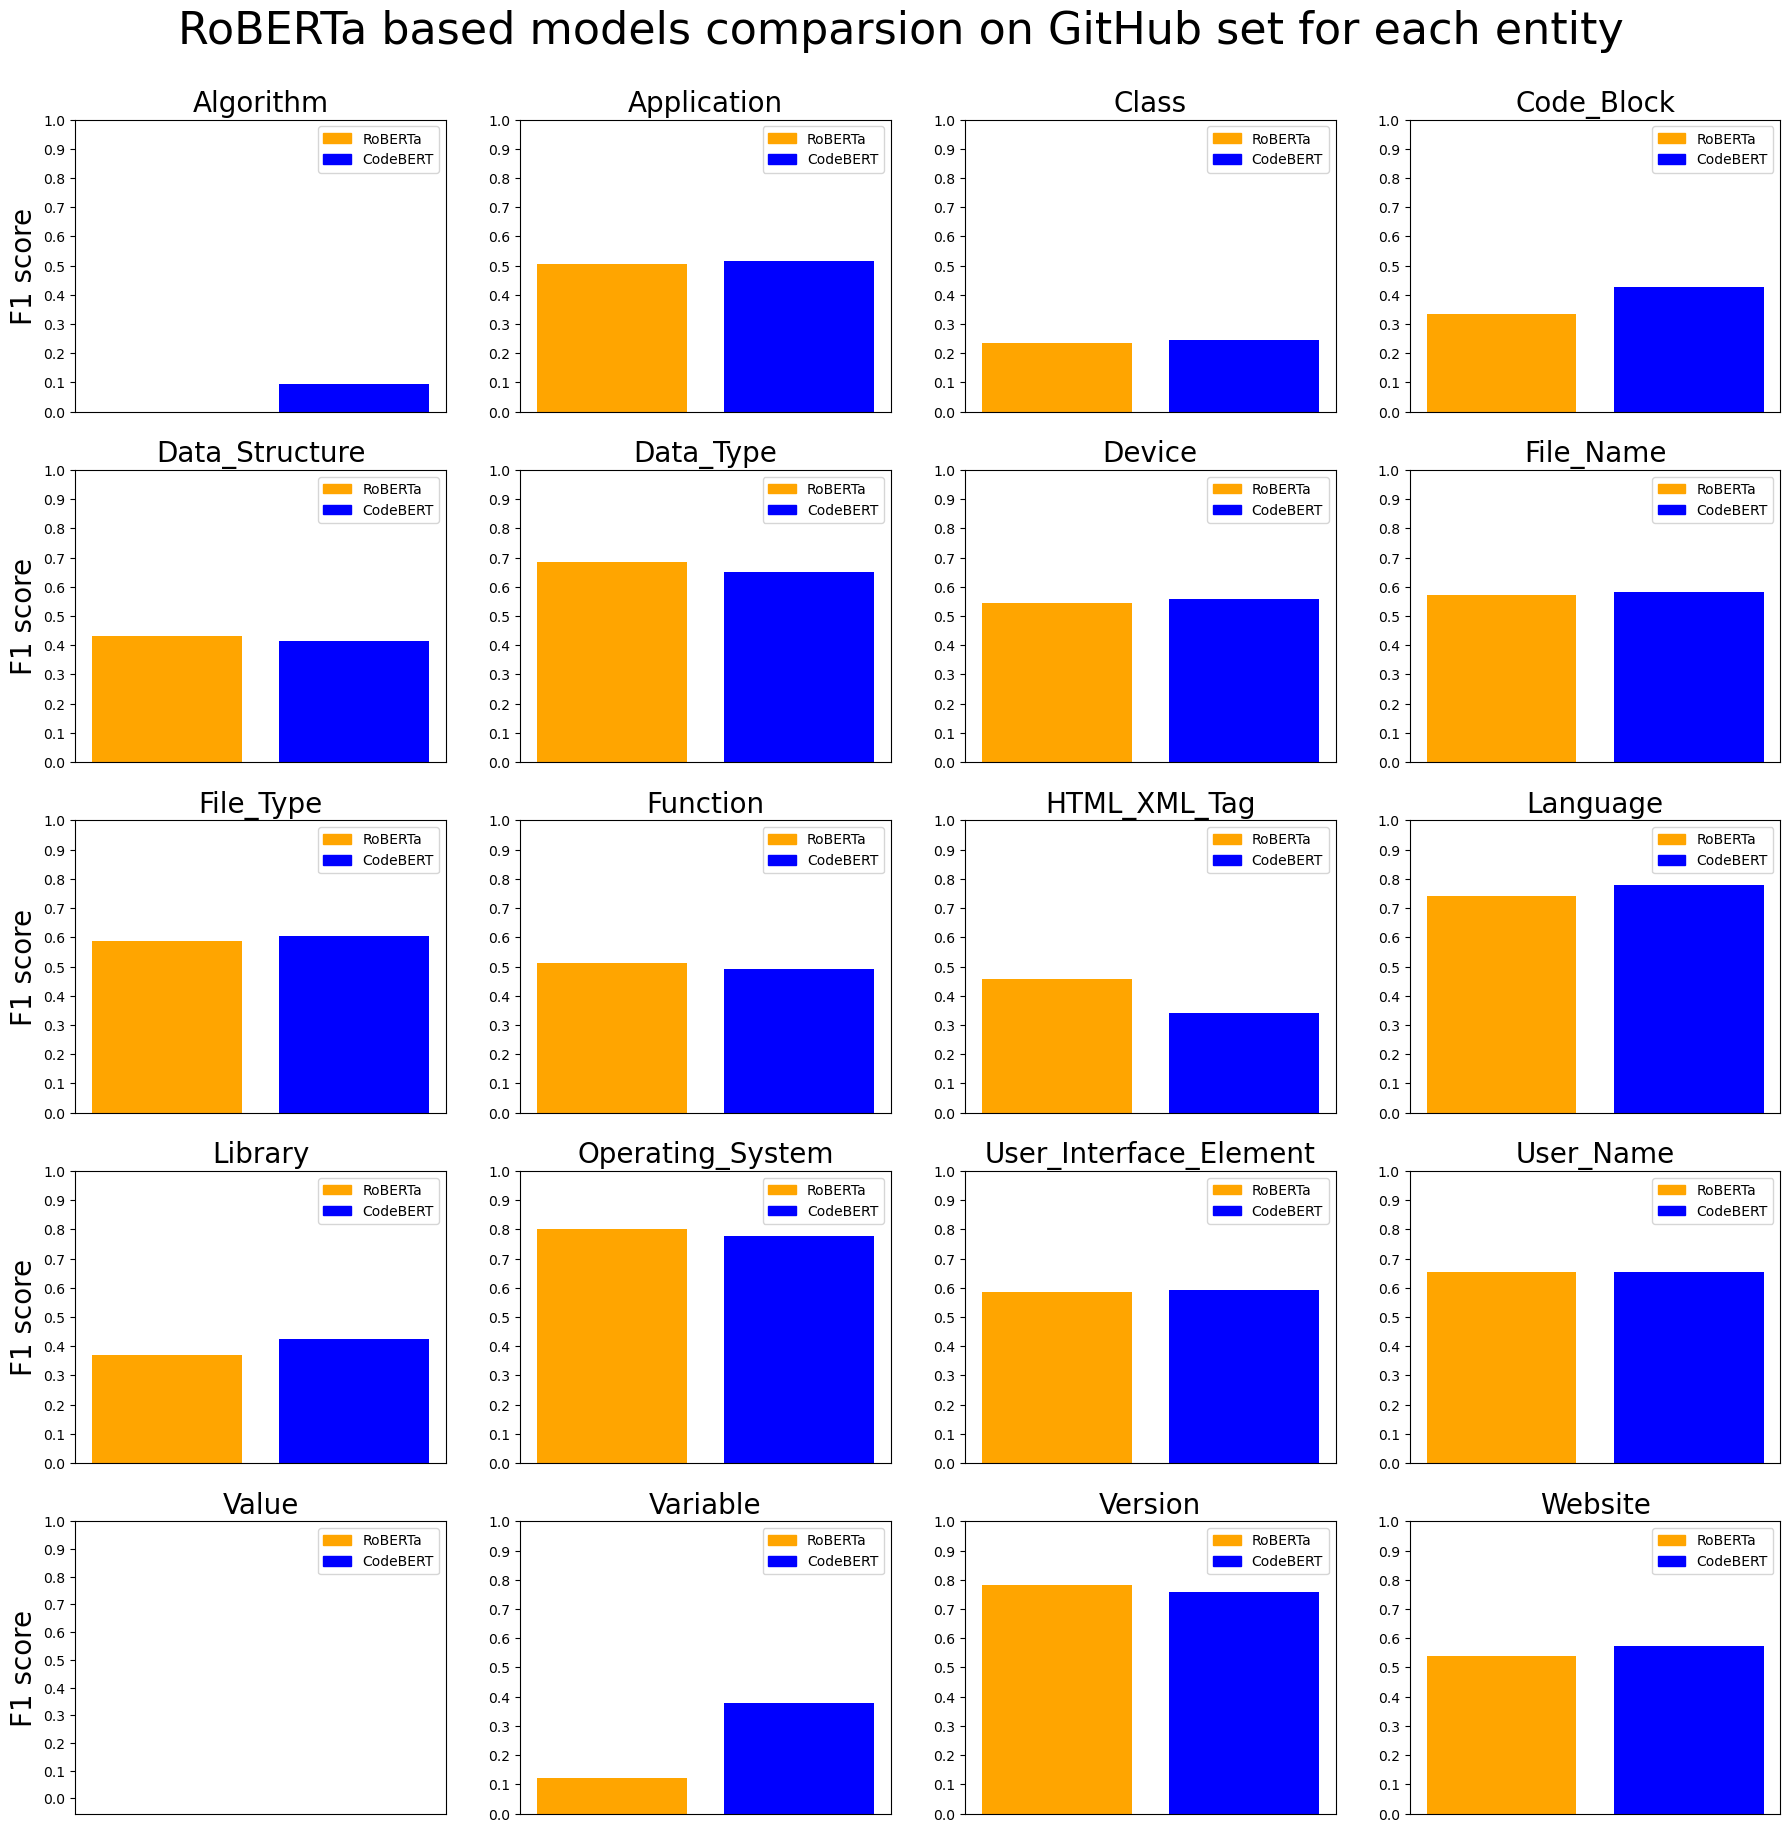

In [38]:
dct_arr = {x: dct[x]["f1"] for x in dct if "overall" not in x}
dct_arr_code = {x: dct_code[x]["f1"] for x in dct_code if "overall" not in x}

data = {
    model_roberta: list(dct_arr.values()),
    model_codebert: list(dct_arr_code.values())
}
length = len(list(dct_arr.values()))
X = [short2long[x] for x in dct_arr.keys()]
colors = ['orange', 'blue']

fig, axes = plt.subplots(5, 4, figsize =(22, 22))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    if i % 4 == 0:
        ax[i].set_ylabel('F1 score', fontsize = size_f1) 
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("RoBERTa based models comparsion on GitHub set for each entity", fontsize=size_each, y=title)
plt.savefig(path_save_image + '4.png', bbox_inches='tight')
plt.show()

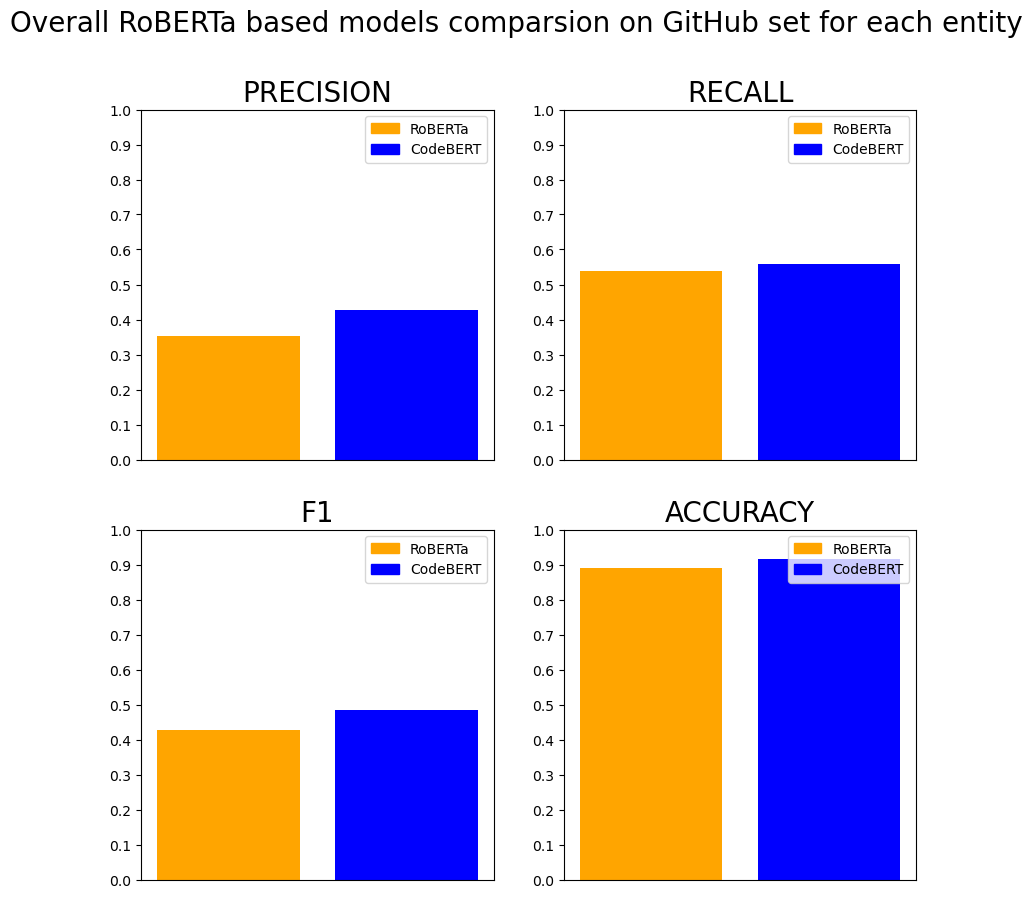

In [39]:
dct_arr = {x: dct[x] for x in dct if "overall"  in x}
dct_arr_code = {x: dct_code[x] for x in dct_code if "overall"  in x}

data = {
    model_roberta: list(dct_arr.values()),
    model_codebert: list(dct_arr_code.values())
}
length = len(list(dct_arr.values()))
X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
colors = ['orange', 'blue']

fig, axes = plt.subplots(2, 2, figsize =(10, 10))
ax = axes.ravel()  

total_width=.8
single_width=.9
n_bars = len(data)
bar_width = total_width / n_bars
handles = [plt.Rectangle((0,0),1,1, color=colors[idx]) for idx, label in enumerate(data.keys())]

for i in range(length):
    temp_class = []
    X_axis = np.arange(len(data))
    for j, key in enumerate(data):
        x_offset = (j - n_bars / 2) * bar_width + bar_width / 2
        temp_class.append(data[key][i])
    
    ax[i].bar(X_axis, temp_class, color=colors)
    ax[i].set_title(X[i], fontsize=size_title)  
    ax[i].set_xticks([])
    ax[i].set_yticks(np.arange(0, 1.1, 0.1))
    ax[i].legend(handles,data.keys(), loc='best', fontsize=size_sqr)


plt.suptitle("Overall RoBERTa based models comparsion on GitHub set for each entity", fontsize=size_ovv)
plt.savefig(path_save_image + '5.png', bbox_inches='tight')
plt.show()

In [21]:
print(f"F1 scores on GitHub domain set:\n\n{model_name} - {dct['overall_f1']}\n{model_code_name} - {dct_code['overall_f1']}")

F1 scores on GitHub domain set:

FacebookAI/roberta-base - 0.4262000897263347
microsoft/codebert-base - 0.4838630607075742
